In [15]:
importlib.reload(mfp)

<module 'MfpDataLib.functions' from '/home/emmett/Projects/Precision Nutrition/IO-with-behavior-Change/MfpDataLib/functions.py'>

# Setup and Load Data

In [4]:
import MfpDataLib 
from MfpDataLib import functions as mfp
import importlib
import pandas as pd
import gurobipy as gp
import numpy as np
from tqdm import tqdm
myEnv = gp.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-09


In [5]:
# Load pre-processed data csv files
goals_df = pd.read_csv("data/raw/myfitnesspal_goals.csv")
meals_df = pd.read_csv("data/raw/myfitnesspal_meals.csv")
goals_df['date'] = pd.to_datetime(goals_df['date'], format="ISO8601")
meals_df['date'] = pd.to_datetime(meals_df['date'], format="ISO8601")
meals_df['full_name'] = meals_df['description']; meals_df = meals_df.drop(columns=['description'])
meals_df['num_servings'] = np.ones(len(meals_df))

# Data Processing

In [26]:
# Create cohorts of users
mfp.process_cohorts(goals_df, goals_df['user_id'].unique())

Manual Goal w/ Change Cohort:  3476 ( 35.13 %)
Manual Goal w/o Change Cohort:  1030 ( 10.41 %)
Automatic Goal w/o Change Cohort:  686 ( 6.93 %)
Automatic Goal w Change Cohort:  4704 ( 47.53 %)


In [7]:
# Summarize size of dataset
print("Dataset contains:")
print("   -", len(goals_df.user_id.unique()), "unique users with a total of", len(goals_df), "daily entries")
print("   -", len(meals_df), "total food entries")
just_food = meals_df.drop(columns=['user_id', 'date', 'meal_name', 'meal_idx'])
just_food['full_name'] = just_food[['food_name', 'brand', 'flavor']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
just_food = just_food.drop_duplicates()
print("   -", len(just_food), "unique food entries (different name, serving size and/or nutrients)")
print("   -", len(just_food['full_name'].unique()), "unique full food names (including brand and flavor)")
# just_food[['full_name', 'food_name', 'brand', 'flavor']].to_csv("data/myfitnesspal/unique_foods.csv")
just_food = just_food.sort_values(by=['full_name'])

# Process and save standardized nutrient references in batches
start=0; stop=5000
tqdm.pandas(desc="Processing rows")
food_ref = mfp.standardize_nutrients(just_food.iloc[start:stop])
food_ref.to_csv("data/temp/nutrient_reference"+str(start)+"-"+str(stop)+".csv")
food_ref.to_pickle("data/temp/nutrient_reference"+str(start)+"-"+str(stop)+".pkl")

Dataset contains:
   - 9896 unique users with a total of 587187 daily entries
   - 6502747 total food entries
   - 2133495 unique food entries (different name, serving size and/or nutrients)
   - 644887 unique full food names (including brand and flavor)
Precomputing value counts...


Columns: 100%|██████████| 4/4 [00:00<00:00, 10.84it/s]


Adding precomputed values to avg_nuts...
Initializing columns for best nutrients...
Processing groups in chunks...


Chunks: 100%|██████████| 2/2 [00:05<00:00,  2.70s/it]

Finalizing best_nuts dataframe... Done.


In [16]:
# Assemble processed nutrient references into a single reference file
ref_df = mfp.compile_standard_nuts()

34906
17453
17453
[]
Precomputing value counts...


Columns: 100%|██████████| 4/4 [00:00<00:00, 7817.90it/s]


Adding precomputed values to avg_nuts...
Initializing columns for best nutrients...
Processing groups in chunks...


Chunks: 0it [00:00, ?it/s]

Finalizing best_nuts dataframe... Done.


In [14]:
print(len(ref_df))
display(ref_df.head())

17453


,Unnamed: 0,full_name,food_name,brand,flavor,serving_size,calories,carbs,fat,protein,sodium,sugar
0,3.0,Fruit Cocktail_Del Monte_100 Calories,Fruit Cocktail,Del Monte,100 Calories,1/2 cup,100.000000,25.0,0.0,0.0,5.0,21.0
1,23.0,Fruit Corner_Muller_Black Cherry and Dark Choc...,Fruit Corner,Muller,Black Cherry and Dark Chocolate,1 pot,170.000000,28.0,3.0,6.0,75.0,26.0
2,24.0,Fruit Corner_Muller_Blackberry and Raspberry Y...,Fruit Corner,Muller,Blackberry and Raspberry Yoghurt,1 pot,161.000000,20.0,6.0,6.0,150.0,20.0
3,28.0,Fruit Corner_Muller_Yoghurt,Fruit Corner,Muller,Yoghurt,175 g,187.000000,24.0,7.0,7.0,0.0,24.0
4,43.0,Fruit Crisp_Dole_Apple Cinnamon,Fruit Crisp,Dole,Apple Cinnamon,1 container,213.333333,30.0,4.0,2.0,20.0,20.0


# Calculating user stats and plotting caloric goals

In [3]:
stats_df = pd.DataFrame(columns=['Person ID',
        'Start Date',
        'End Date',
        'Days Active',
        'Days active to span Ratio',
        'Days Logged',
        'Average Days Between Entry',
        'Median Days Between Entry',
        'Standard Deviation Days Betweeen Entry',
        'Longest Hiatus (Days)',
        'Average Meals Per Day',
        'Median Meals Per Day',
        'Standard Deviation Meals',
        'Average Calorie Goal',
        'Standard Deviation Calorie Goal',
        'Median Calorie Goal',
        'Average Calories Consumed per Day',
        'Standard Deviation Calories Consumed',
        'Median Calories Consumed per Day'])

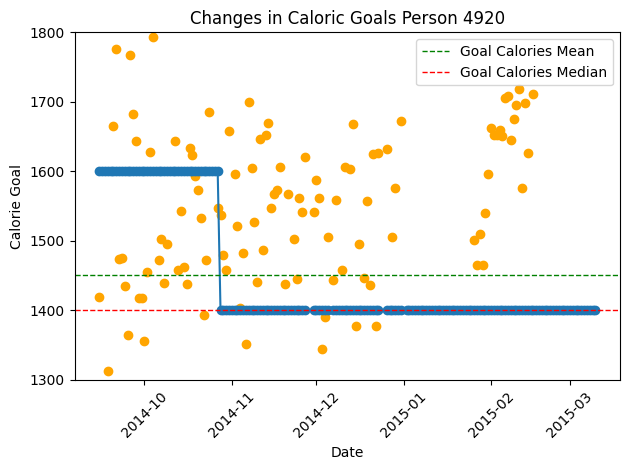

,Person ID,Start Date,End Date,Days Active,Days active to span Ratio,Days Logged,Average Days Between Entry,Median Days Between Entry,Standard Deviation Days Betweeen Entry,Longest Hiatus (Days),Average Meals Per Day,Median Meals Per Day,Standard Deviation Meals,Average Calorie Goal,Standard Deviation Calorie Goal,Median Calorie Goal,Average Calories Consumed per Day,Standard Deviation Calories Consumed,Median Calories Consumed per Day
0,4920,2014-09-15,2015-03-10,171,0.966102,177,1,1,0,3,3.766082,4.0,0.556477,1450,87,1400,1342,421,1476


In [4]:
stats_df = mfp.calc_user_stats(4920, goals_df, meals_df, stats_df)
display(stats_df)

# IO Models & Results Plotting

In [27]:
userID = 4920
userGoals = goals_df[goals_df['user_id']==userID]
userMeals = meals_df[meals_df['user_id']==userID]
mfp.init_user(userID, userGoals, userMeals, print_stats=True)  

User 4920 has 171 daily entries with 212 total unique food items


In [28]:
dates=[userGoals.iloc[0].date]
UB_flex = [0.1, 0.5, 0, 0.5, 0.1, 0.5]
LB_flex = [0.3, 0.8, 1, 0.3, 0.9, 1]
A, b, X, foods = mfp.model_params(userGoals, userMeals, dates, UB_flex, LB_flex)
# TEMP: Tile A so that it is p-dimensional for the p observations
A = np.tile(A,(X.shape[0],1,1))

18 food entries (14 unique foods) eaten in date range.


In [29]:
IO_D_results = mfp.IO_M(A,b,X,myEnv,noiseType='abs', x_noise=True)

Optimal objective value =  4.56013986013986


In [30]:
IO_M_results = mfp.IO_M(A,b,X,myEnv,noiseType='abs', x_noise=True, A_noise=True)

Optimal objective value =  4.560139860139812


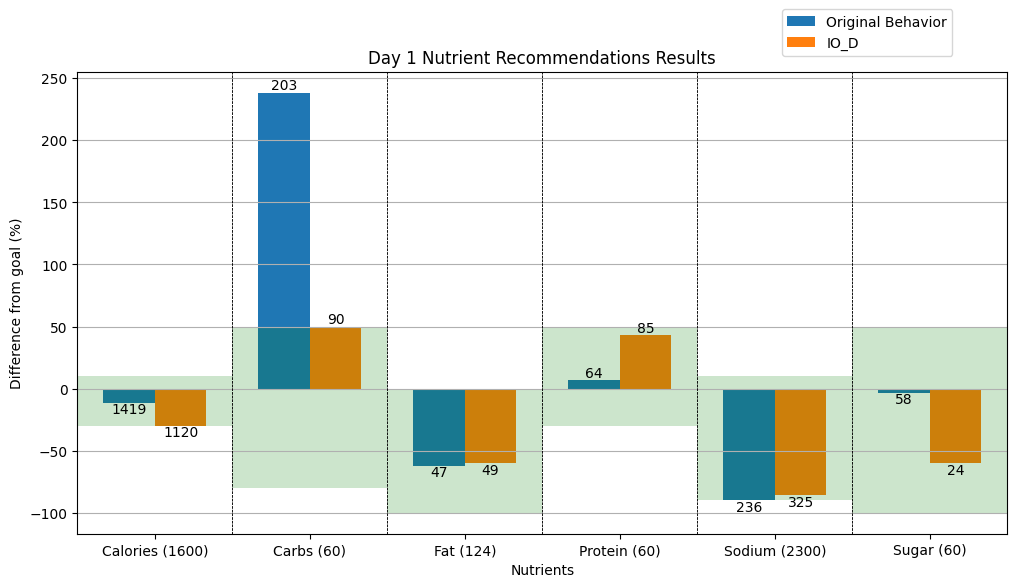

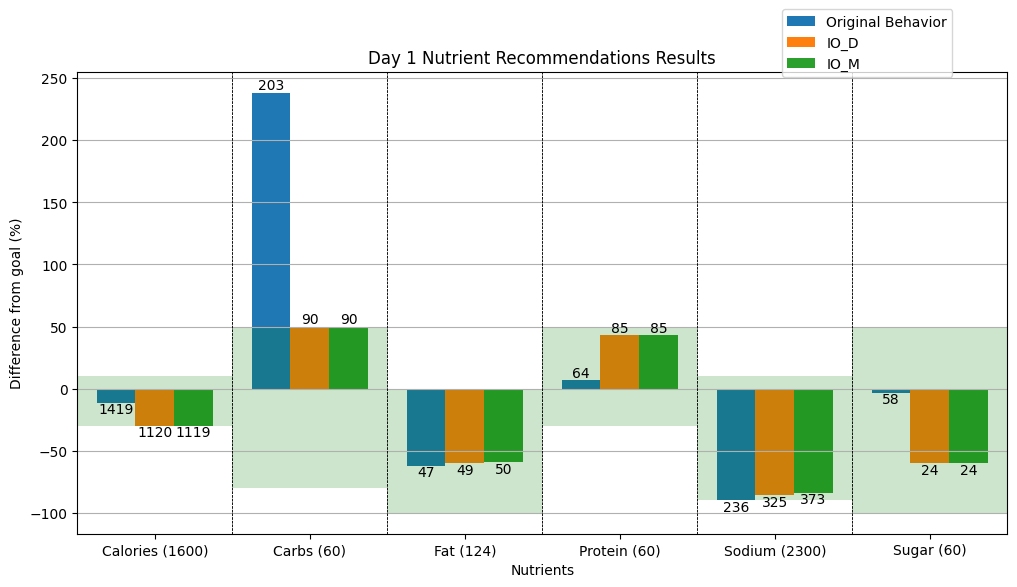

In [82]:
mfp.plt_rec_nuts(userID, userGoals, dates, A[0], b[0], X, 0, 0, [IO_D_results], ["IO_D"])
mfp.plt_rec_nuts(userID, userGoals, dates, A[0], b[0], X, 0, 0, [IO_D_results, IO_M_results], ["IO_D", "IO_M"])

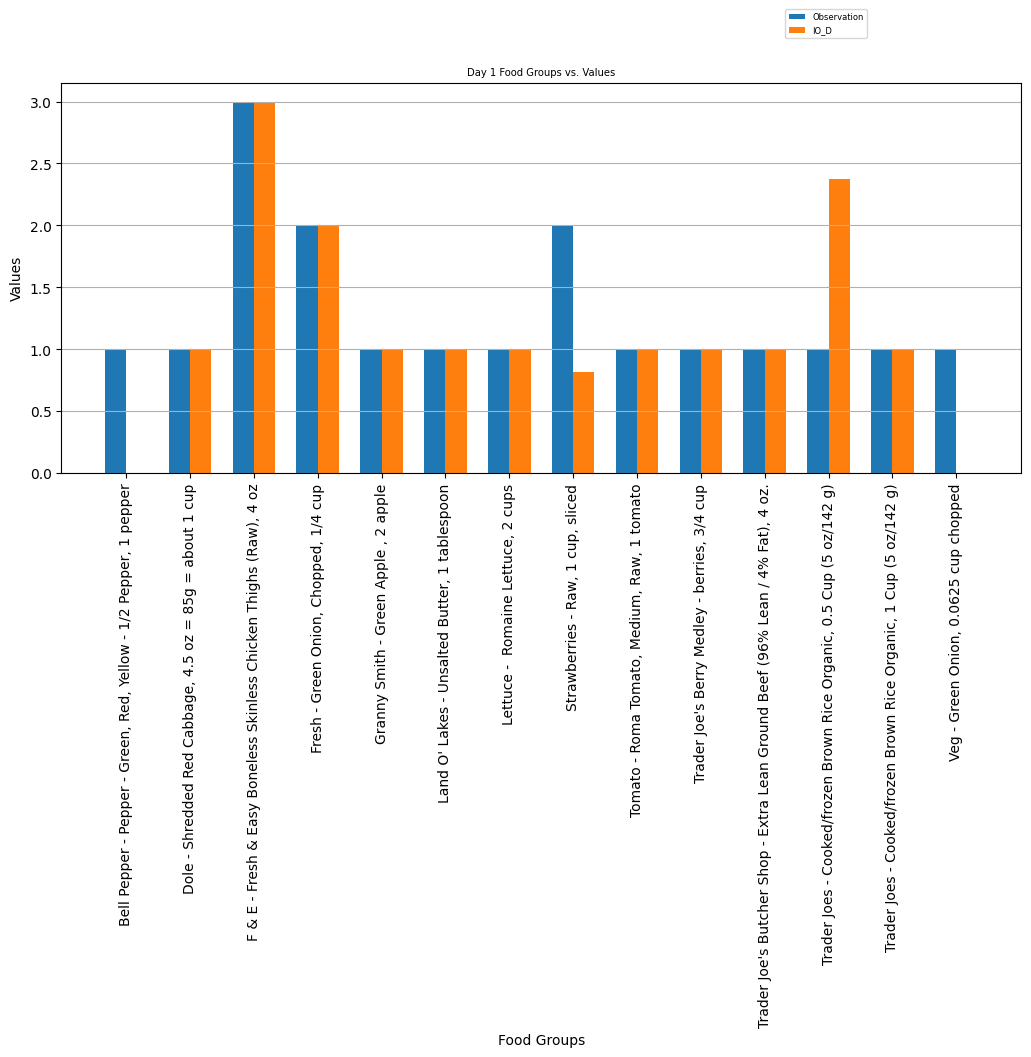

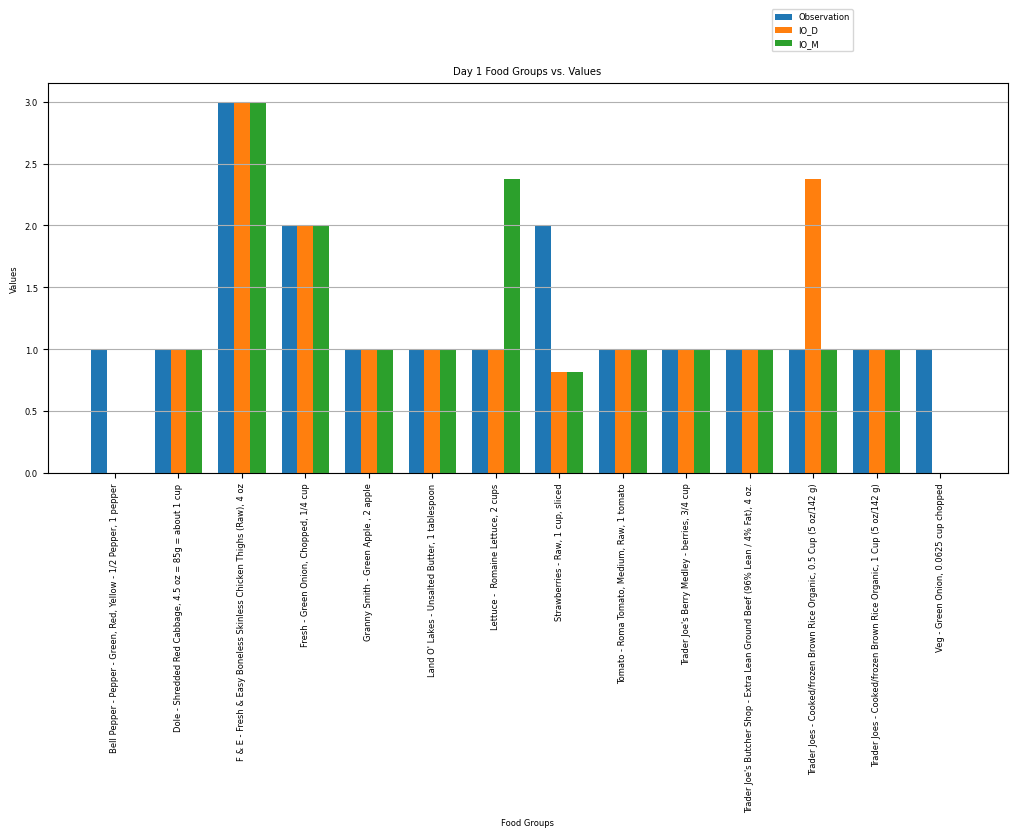

In [83]:
mfp.plt_rec_foods(userID, X, foods, 0, [IO_D_results], ["IO_D"])
mfp.plt_rec_foods(userID, X, foods, 0, [IO_D_results, IO_M_results], ["IO_D", "IO_M"])

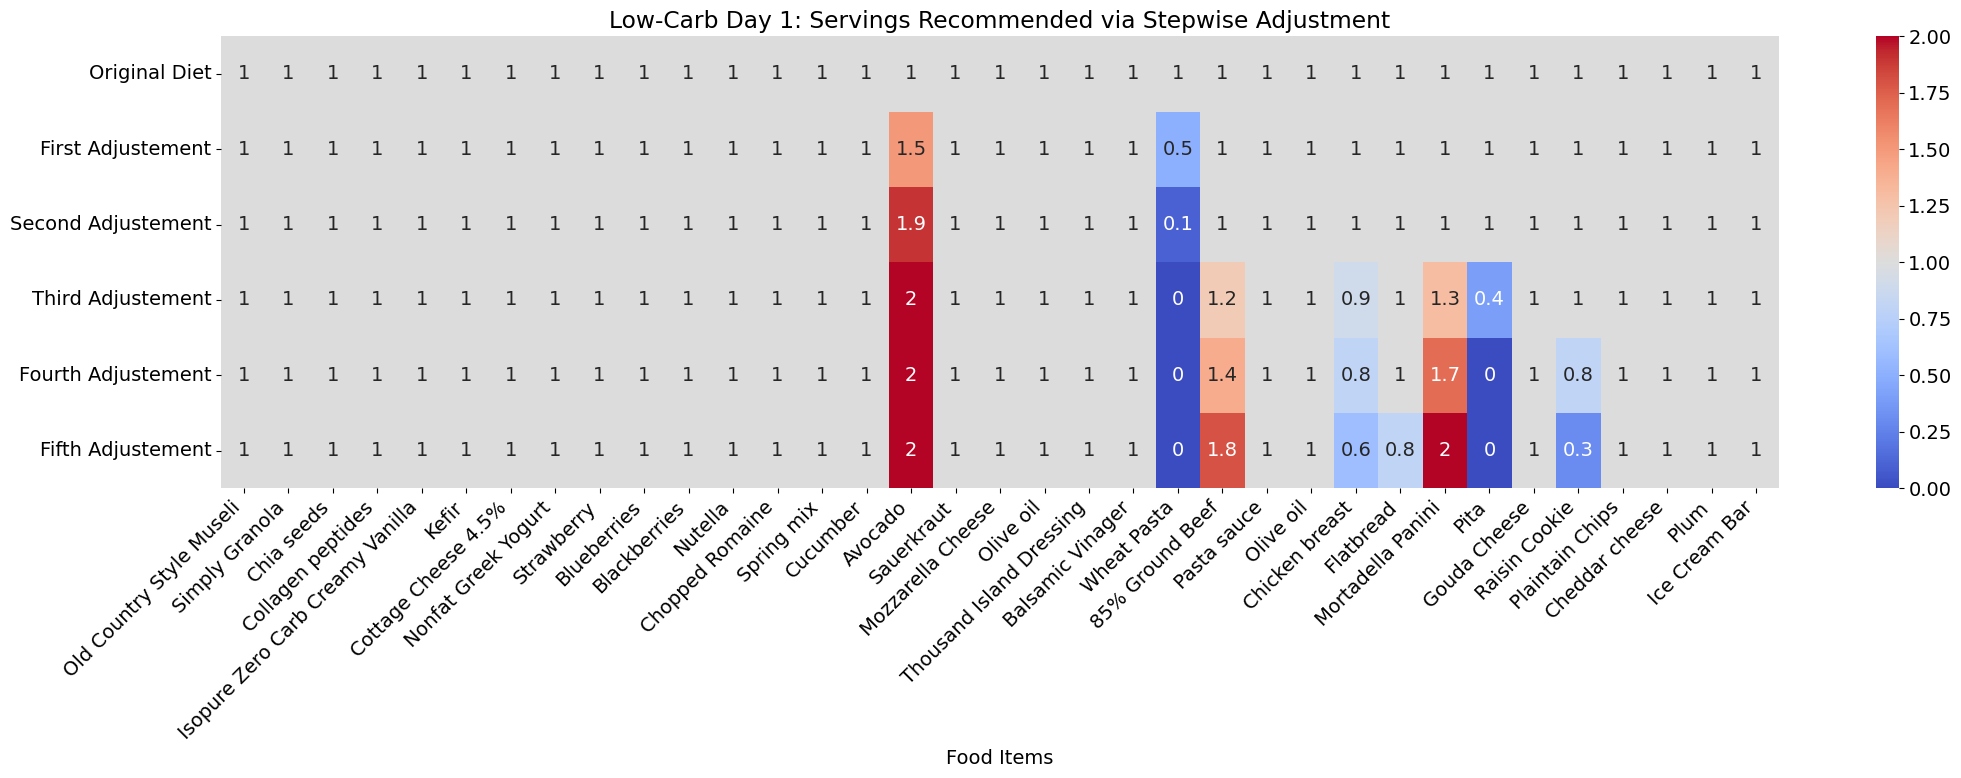

In [91]:
mfp.plt_stepwise('data/temp/fig2.csv')